<div style="float:left;font-size:20px;">
    <h1>Interpolation</h1>
</div><div style="float:right;"><img src="../assets/banner.jpg"></div>

Illustrate option pricing with interpolation pricing and machine learning?

In [1]:
import QuantLib as ql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Option Configuration

In [2]:
maturity_date = ql.Date(15, 1, 2016)
spot_price    = 125
strike_price  = 130
volatility    = 0.20 # the historical vols or implied vols
dividend_rate = 0.0163
option_type   = ql.Option.Call

## Market configuration

In [3]:
risk_free_rate = 0.001
day_count      = ql.Actual365Fixed()
calendar       = ql.UnitedStates()

calculation_date = ql.Date(8, 5, 2015)
ql.Settings.instance().evaluationDate = calculation_date

## Option objects

In [4]:
payoff          = ql.PlainVanillaPayoff(option_type, strike_price)
settlement      = calculation_date

am_exercise     = ql.AmericanExercise(settlement, maturity_date)
american_option = ql.VanillaOption(payoff, am_exercise)

eu_exercise     = ql.EuropeanExercise(maturity_date)
european_option = ql.VanillaOption(payoff, eu_exercise)

## Simulation model - Black-Scholes-Merton

In [5]:
spot_handle = ql.QuoteHandle(
    ql.SimpleQuote(spot_price)
)

flat_ts = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, risk_free_rate, day_count)
)

dividend_yield = ql.YieldTermStructureHandle(
    ql.FlatForward(calculation_date, dividend_rate, day_count)
)

flat_vol_ts = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(calculation_date, calendar, volatility, day_count)
)

bsm_process = ql.BlackScholesMertonProcess(spot_handle,
                                           dividend_yield,
                                           flat_ts,
                                           flat_vol_ts)

## Option Pricing

### Theoretical European option price

In [6]:
european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
bs_price = european_option.NPV()
print(bs_price)

5.6122204198955075


### Binomial tree pricing

In [79]:
def binomial_price(option, bsm_process, steps):
    binomial_engine = ql.BinomialVanillaEngine(bsm_process, "crr", steps)
    option.setPricingEngine(binomial_engine)
    return option.NPV()

min_steps = 5
max_steps = 500

steps = range(min_steps, max_steps)
eu_prices = [binomial_price(european_option, bsm_process, step) for step in steps]
am_prices = [binomial_price(american_option, bsm_process, step) for step in steps]

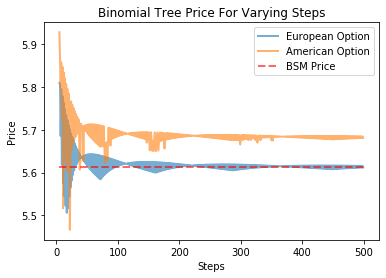

In [8]:
plt.plot(steps, eu_prices, label="European Option", lw=2, alpha=0.6)
plt.plot(steps, am_prices, label="American Option", lw=2, alpha=0.6)
plt.plot([min_steps, max_steps], [bs_price, bs_price], "r--", label="BSM Price", lw=2, alpha=0.6)
plt.xlabel("Steps")
plt.ylabel("Price")
#plt.ylim(6.7, 7)
plt.title("Binomial Tree Price For Varying Steps")
plt.legend()

In [9]:
def price_convergence_measure(price):
    diff = np.array(price) - np.roll(price, -1)
    return diff[:-1]

In [10]:
price_convergence_measure(am_prices)[-10:]

array([-0.00444957,  0.00432494, -0.00427525,  0.00415393, -0.00410268,
        0.00398416, -0.00393173,  0.00381615, -0.00376316,  0.00365023])

In [11]:
%timeit binomial_price(american_option, bsm_process, 1000)

8.5 ms ± 769 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Interpolation pricing

In [12]:
min_strike = spot_price - 100
max_strike = spot_price + 100

### Brute force

In [80]:
def strike_prices(strikes, n_steps=1000, settlement=settlement, maturity_date=maturity_date):
    am_exercise     = ql.AmericanExercise(settlement, maturity_date)
    american_options = [ql.VanillaOption(ql.PlainVanillaPayoff(option_type, strike), am_exercise) for strike in strikes]
    prices = [binomial_price(american_option, bsm_process, n_steps) for american_option in american_options]
    return strikes, prices

In [14]:
def scan_strike_prices(strike_min, strike_max, n_strikes=100, n_steps=1000):
    strikes = np.linspace(strike_min, strike_max, n_strikes)
    return strike_prices(strikes, n_steps)

In [23]:
# 726 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
strikes, prices = scan_strike_prices(min_strike, max_strike)

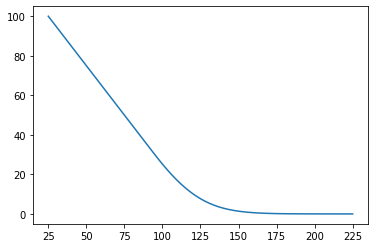

In [24]:
plt.plot(strikes, prices)

### Interpolation (1D)

In [25]:
from scipy import interpolate

In [26]:
f_inter = interpolate.interp1d(strikes, prices, kind='cubic')

In [27]:
strike_test = np.linspace(min_strike, max_strike, 7)
price_test = f_inter(strike_test)
price_error = price_test - strike_prices(strike_test)[1]

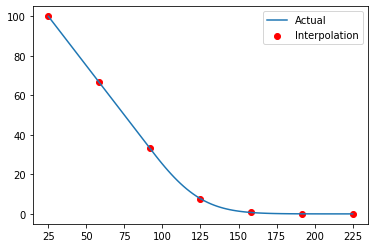

In [28]:
plt.scatter(strike_test, price_test, c='r', label='Interpolation')
plt.plot(strikes, prices, label='Actual')
plt.legend()

#### Interpolation error

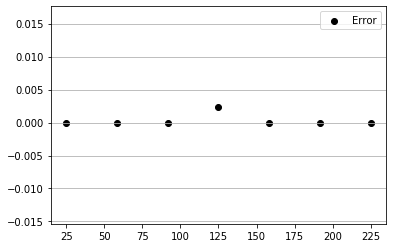

In [29]:
plt.scatter(strike_test, price_error, c='black', label='Error')
plt.grid(b=True, which='major', axis='y', linestyle='-')
plt.legend()

### Interpolation (2D)

In [59]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]

# Actual results
grid_z_actual = func(grid_x, grid_y)

# Only know values at 1000 points
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

# Grid interpolation
from scipy.interpolate import griddata
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

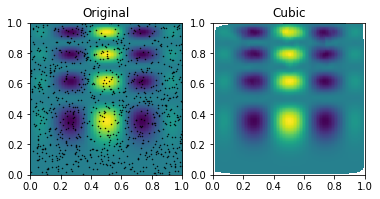

In [60]:
# Original
plt.subplot(121)
plt.imshow(grid_z_actual.T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')

# Interpolation
plt.subplot(122)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic');

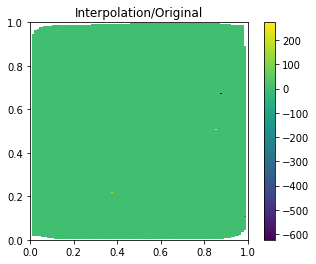

In [74]:
ratio = grid_z_actual/grid_z2

plt.imshow(ratio.T, extent=(0,1,0,1), origin='lower')
plt.colorbar()
plt.title('Interpolation/Original');

In [81]:
def am_option_price(strike, day_delta, settlement_date, maturity_date, steps=500):
    am_exercise     = ql.AmericanExercise(settlement, maturity_date)
    american_option = ql.VanillaOption(ql.PlainVanillaPayoff(option_type, strike), am_exercise)
    price = binomial_price(american_option, bsm_process, steps)
    return price

In [82]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2

grid_strike, grid_mat = np.mgrid[100:200:100j, 0:1:200j]

100j

In [84]:
a = ql.Date(8, 5, 2015)
a += 1
a

Date(9,5,2015)

## Chebyshev

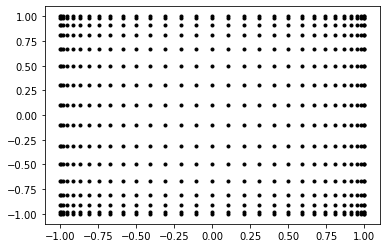

In [30]:
import numpy as np
import matplotlib.pyplot as plt
N = 30
M = 15
x = np.cos (np.pi * np.arange(N + 1) / N)
y = np.cos (np.pi * np.arange(M + 1) / M)
xx, yy = np.meshgrid(x, y)
plt.plot(xx, yy, "ko", markersize = 3);

In [31]:
x = np.arange(N + 1)
y = np.arange(N + 1)
c = np.arange(N + 1)
np.polynomial.chebyshev.Chebyshev.interpolate(, 3)

SyntaxError: invalid syntax (<ipython-input-31-669e54416b06>, line 4)

## Trade population

In [32]:
n_trades = 100
tickers = ['AAPL', 'SPY']
currencies = ['USD']
products = ['AmericanOption']
maturities = [ql.Date(15, 1, 2016)]

np.random.seed(42)
quantities = np.linspace(-100000, 100000, 21)

tick_data = pd.DataFrame({'Ticker': tickers,
                          'Spot': np.random.randint(100, 200, len(tickers)),
                          'DividendRate': np.random.uniform(0.005, 0.015, len(tickers)),
                         })
tick_data

,Ticker,Spot,DividendRate
0,AAPL,151,0.006834
1,SPY,192,0.012797


In [33]:

population = pd.DataFrame({'TradeID': ['EQ{}'.format(i + 1) for i in range(n_trades)],
                           'Ticker': np.random.choice(tickers, size=n_trades),
                           'Currency': np.random.choice(currencies, size=n_trades),
                           'Product': np.random.choice(products, size=n_trades),
                           'Call': np.random.choice([True, False], size=n_trades),
                           'Maturity': np.random.choice(maturities, size=n_trades),
                           'Quantity': np.random.choice(quantities, size=n_trades),
                          })
population['Strike'] = population.apply(lambda row: tick_data[tick_data['Ticker']==row['Ticker']]['Spot'].values[0], axis=1)
population['Instrument'] = population['Ticker'] + '.' + population['Strike'].astype('str') + '.' + population['Call'].astype('str')
population

,TradeID,Ticker,Currency,Product,Call,Maturity,Quantity,Strike,Instrument
0,EQ1,AAPL,USD,AmericanOption,False,"January 15th, 2016",-70000.0,151,AAPL.151.False
1,EQ2,AAPL,USD,AmericanOption,False,"January 15th, 2016",-60000.0,151,AAPL.151.False
2,EQ3,SPY,USD,AmericanOption,True,"January 15th, 2016",-40000.0,192,SPY.192.True
3,EQ4,AAPL,USD,AmericanOption,False,"January 15th, 2016",20000.0,151,AAPL.151.False
4,EQ5,AAPL,USD,AmericanOption,True,"January 15th, 2016",40000.0,151,AAPL.151.True
...,...,...,...,...,...,...,...,...,...
95,EQ96,SPY,USD,AmericanOption,True,"January 15th, 2016",-40000.0,192,SPY.192.True
96,EQ97,SPY,USD,AmericanOption,True,"January 15th, 2016",50000.0,192,SPY.192.True
97,EQ98,SPY,USD,AmericanOption,False,"January 15th, 2016",50000.0,192,SPY.192.False
98,EQ99,SPY,USD,AmericanOption,True,"January 15th, 2016",90000.0,192,SPY.192.True


In [34]:
tick_data

,Ticker,Spot,DividendRate
0,AAPL,151,0.006834
1,SPY,192,0.012797
